## Motivating Support Vector Machines

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated. Can you decide a separating line for the classes?

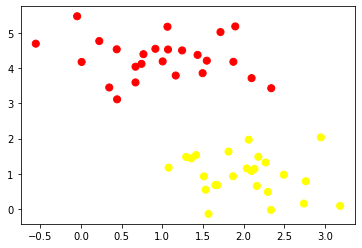

In [1]:
# please run this cell 

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

plt.show()

#I changed the third import statement since I received an error when running the provided code. 

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

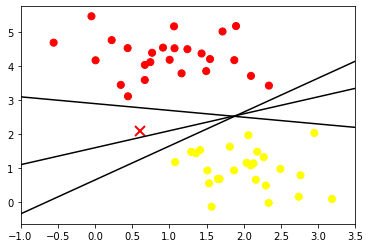

In [2]:
# please run this cell 

xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the `"X"` in this plot) will be assigned a different label! 
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Maximizing the Margin

Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a **margin** of some width, up to the nearest point. Here is an example of how this might look:

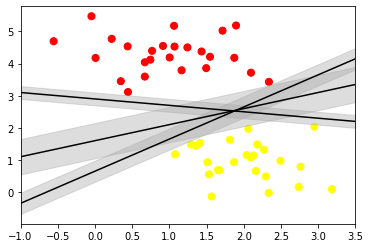

In [3]:
# please run this cell 

xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a **maximum margin** estimator.

## Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use [Scikit-Learn's support vector classifier](https://scikit-learn.org/stable/modules/svm.html) to train an SVM model on this data.   
For the time being, we will use a `linear kernel` and set the `C` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

First, import the SVM module.

```
from sklearn.svm import SVC 
```

Create a `SVC` object and name it as `model`.

```python
model = SVC(kernel='linear', C=1E10)
```

Then, fit the model on train set using `.fit()`.
```
model.fit(X, y)
```

In [4]:
# import the SVM module.

from sklearn.svm import SVC

# Create a SVC object and name it as model.

model = SVC(kernel='linear', C=1E10)

# fit the model on train set  

model.fit(X, y)

print(model)

SVC(C=10000000000.0, kernel='linear')


To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

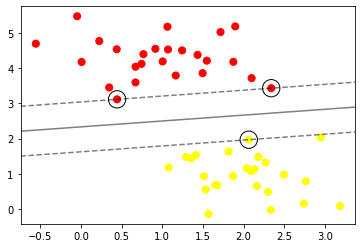

In [5]:
# please run this cell 

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """
    Plot the decision function for a 2D SVC
    """
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    
    
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)
plt.show()

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the **support vectors**, and give the algorithm its name. 

In Scikit-Learn, the identity of these points are stored in the `support_vectors_` attribute of the classifier:

```python
model.support_vectors_
```

In [6]:
# print out the support vectors 

print(model.support_vectors_)


[[0.44359863 3.11530945]
 [2.33812285 3.43116792]
 [2.06156753 1.96918596]]


A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

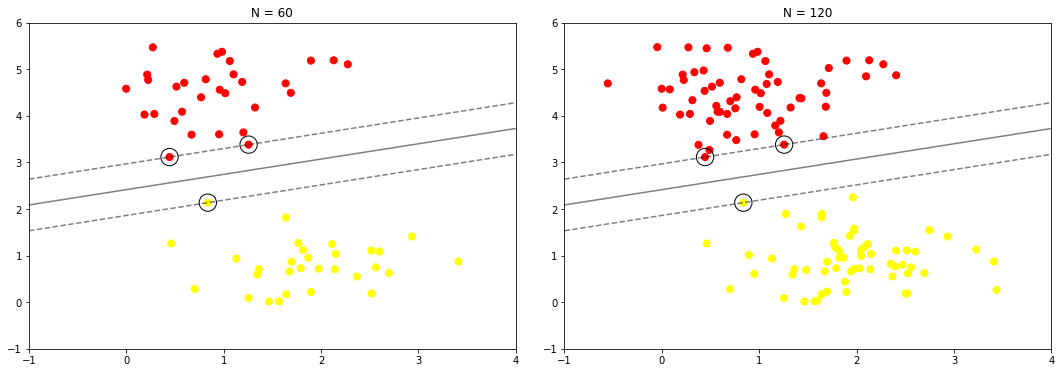

In [7]:
# please run this cell 

def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))


In the left panel, we see the model and the support vectors for 60 training points.   
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.   
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

We can use IPython's interactive widgets to view this feature of the SVM model interactively. Please run the cell below and change the value of `N`.

interactive(children=(Dropdown(description='N', options=(10, 30, 60, 90, 120, 150, 180, 200), value=10), Outpu…

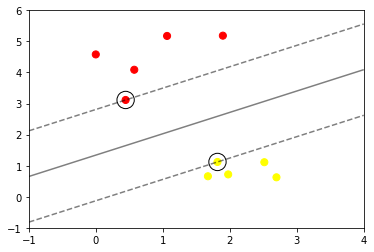

In [8]:
# please run this cell 

from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 30, 60, 90, 120, 150, 180, 200], ax=fixed(None));

*** 
*** 
## Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with **kernels**.

We projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea. To motivate the need for kernels, let's look at some data that is not linearly separable:

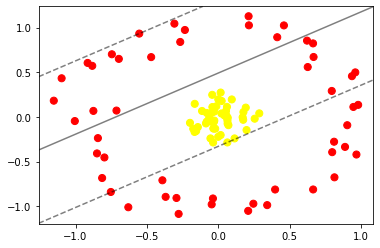

In [9]:
# please run this cell 
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

It is clear that no linear discrimination will ever be able to separate this data. 
How we might project the data into a higher dimension such that a linear separator would be sufficient?  
For example, one simple projection we could use would be to compute a [radial basis function](https://en.wikipedia.org/wiki/Radial_basis_function) centered on the middle clump:

```python
r = np.exp(-(X ** 2).sum(1))
```

We can visualize this extra data dimension using a three-dimensional plot— we will be able to use the sliders to rotate the plot. 
Change the value of `elev` and `azim`.

interactive(children=(Dropdown(description='elev', options=(-90, 0, 90), value=-90), IntSlider(value=30, descr…

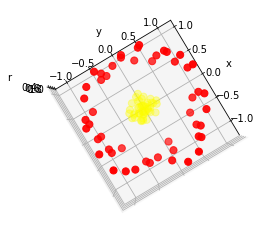

In [10]:
# please run this cell 

from mpl_toolkits import mplot3d

r = np.exp(-(X ** 2).sum(1))

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 0, 90], azip=(-180, 180), X=fixed(X), y=fixed(y));

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, `r=0.7`.

Here we had to choose and carefully tune our projection: if we had not centered our `radial basis function` in the right location, we would not have seen such clean, linearly separable results. In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. This type of basis function transformation is known as a `kernel transformation`, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large. However, because of a neat little procedure known as the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$ dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the `kernel` model hyperparameter.
```python
clf = SVC(kernel='rbf', C=1E6)
```

In [11]:
# Create a SVC object and name it as clf
# use the `kernel` parameter and let it equal to `rbf`

clf = SVC(kernel='rbf', C=1E6)

# fit the new model on train set  
clf.fit(X, y)


print(clf)

SVC(C=1000000.0)


# Please run this cell 
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=300, lw=1, facecolors='none', edgecolors='black')

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary. This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

## Tuning the SVM: Softening Margins
Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists. But what if your data has some amount of overlap? For example, you may have data like this:

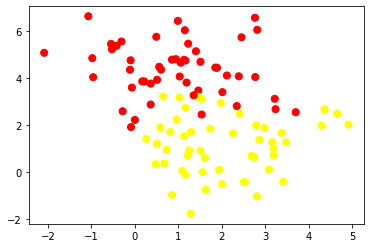

In [12]:
# please run this cell 
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as $C$. For very large $C$, the margin is hard, and points cannot lie in it. For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

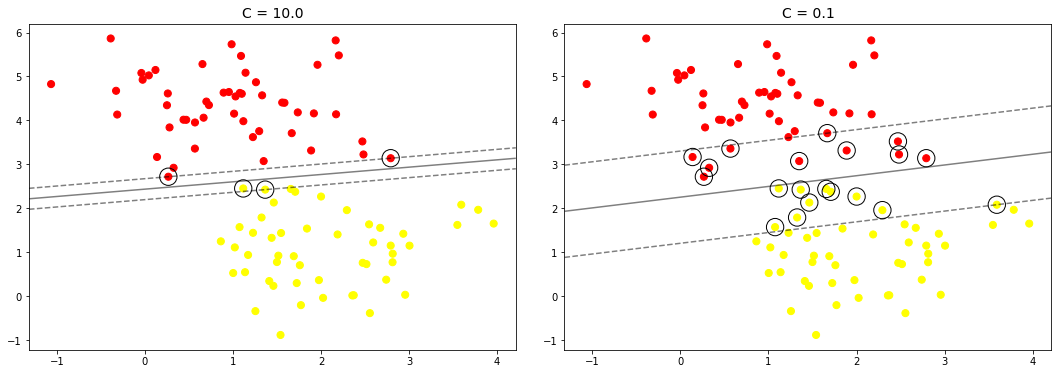

In [13]:
# please run this cell 

X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.

***
***
### PRACTICAL PROJECT
## Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem. We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures. A fetcher for the dataset is built into Scikit-Learn.

1. Import the dataset from `sklearn`:
```python
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
```

We can print out the `target_names` and the shape of the dataset:
```
print(faces.target_names)
print(faces.images.shape)
```

In [14]:

# Import the dataset from sklearn

from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)



# print out the target_names and the shape of the dataset:

print(faces.target_names)
print(faces.images.shape)


['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


2. Let's plot a few of these faces to see what we're working with:
```python
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])
```    

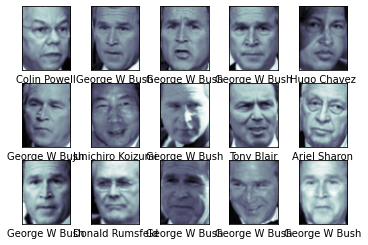

In [15]:
# plot a few of these faces 
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
 axi.imshow(faces.images[i], cmap='bone')
 axi.set(xticks=[], yticks=[],
         xlabel=faces.target_names[faces.target[i]])

3. Each image contains `[62×47]` or nearly `3,000` pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to extract 150 fundamental components to feed into our support vector machine classifier.  
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

```python
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)
```

In [16]:
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

# packaging the preprocessor and the classifier into a single pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

#I changed the first import statement since I received an error when using the provided import statement. 

4. For the sake of testing our classifier output, we will split the data into a training and testing set:
```python
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)
```

In [17]:
from sklearn.model_selection import train_test_split

# split the data into a training and testing set

Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)


5. 
Finally, we can use a grid search cross-validation to explore combinations of parameters. Here we will adjust $C$ (which controls the margin hardness) and $gamma$ (which controls the size of the radial basis function kernel), and determine the best model:

```python
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=5)

grid.fit(Xtrain, ytrain)
```

In [18]:
from sklearn.model_selection import GridSearchCV

# use a grid search cross-validation to choose best C and gamma 

print("Fitting the classifier to the training set")

# your code here

param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=5)

grid.fit(Xtrain, ytrain)

print(grid.best_params_)

Fitting the classifier to the training set
{'svc__C': 10, 'svc__gamma': 0.001}


6. Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:
```python
model = grid.best_estimator_
yfit = model.predict(Xtest)
```

In [21]:
# predict the labels for the test data

model = grid.best_estimator_
yfit = model.predict(Xtest)


7. Let's take a look at a few of the test images along with their predicted values:
```python
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
```

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

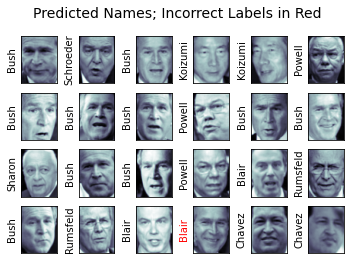

In [22]:
# plot the test images 


fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s face in the bottom row was mislabeled as Blair). 

8. We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

```python
print(classification_report(ytest, yfit, target_names=faces.target_names))
```

In [23]:
from sklearn.metrics import classification_report

# print out the classification report

print(classification_report(ytest, yfit, target_names=faces.target_names))



                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



9. We might also display the confusion matrix between these classes:
```python
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
```

Text(89.18, 0.5, 'predicted label')

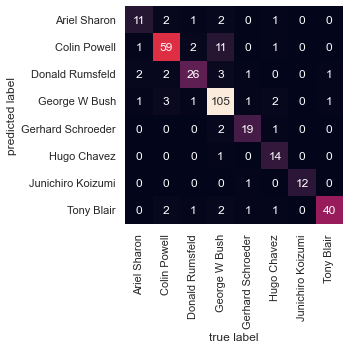

In [24]:
from sklearn.metrics import confusion_matrix
# use seaborn plotting defaults
import seaborn as sns; sns.set()

# display the confusion matrix between these classes

mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
         xticklabels=faces.target_names,
         yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')



This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation. For this kind of application, one good option is to make use of [OpenCV](https://opencv.org/), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

## Review
We have seen here a brief intuitive introduction to the principals behind support vector machines. These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.